<div style="width: 100%; overflow: hidden;">
    <a href="http://www.uc.pt/fctuc/dei/">
    <div style="display: block;margin-left: auto;margin-right: auto; width: 50%;"><img src="https://eden.dei.uc.pt/~naml/images_ecos/dei25.png"  /></div>
    </a>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

print(device)

cpu


In [2]:
# Define the directory where your images are
image_directory = 'data-students\\TRAIN'

In [3]:
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

train_dataset = ImageFolder(root=image_directory, transform=transform)


print(train_dataset.class_to_idx)  # Mostra todas as classes e seus índices

# Suponha que você quer apenas a classe cujo nome é 'class_name'
target_class = '6'
target_class_index = train_dataset.class_to_idx[target_class]

# Filtrar índices
target_indices = [i for i, (img, label) in enumerate(train_dataset) if label == target_class_index]

# Criar subset apenas com a classe desejada
target_dataset = Subset(train_dataset, target_indices)

# DataLoader para o subset
train_loader = DataLoader(target_dataset, batch_size=128, shuffle=True)


{'12': 0, '13': 1, '24': 2, '38': 3, '39': 4, '44': 5, '46': 6, '49': 7, '50': 8, '6': 9}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


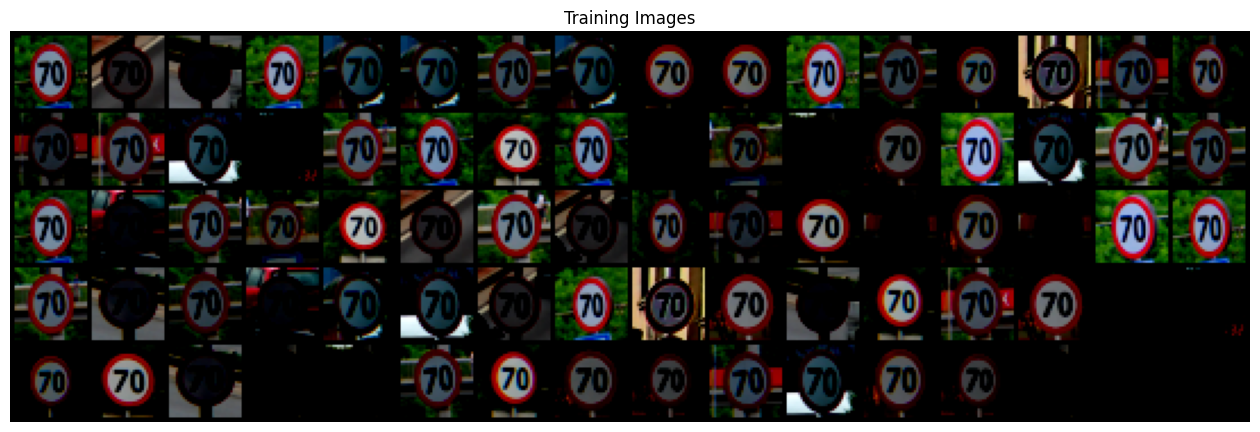

In [4]:
## show some images from train_loader

for images, labels in train_loader:
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(images, nrow=16).cpu(), (1, 2, 0)))
    break

In [5]:
def show_images(images):
    plt.figure(figsize=(8, 8))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(np.transpose(images[i].detach().cpu().numpy(), (1, 2, 0)), interpolation='nearest')
        plt.axis('off')
    plt.show()

<h2><font color='#172241'>1. Introduction</font></h2>

In this class we are going to discuss and implement Generative Adversarial Networks (GANs). A GAN combines two deep neural networks: a discriminator D and a generator G. The generator G receives a noise as input and outputs a fake sample, trying to replicate the data distribution used as input for D. The discriminator D receives the real data and fake samples as input, and tries to distinguish between them. These components are trained simultaneously as adversaries, hopefully creating strong generative and discriminative components. Then image bellow presents an overview of the entire process.

<img src="GANDiagram.png">


Over the years several GANs models and architectures have been proposed in the literature [\[1\]](https://arxiv.org/abs/1701.07875)[\[2\]](https://arxiv.org/abs/1912.04958). These models are quite advanced and produce impressive results but they require large ammounts of computational resources.

In our case we are going to implement a Deep Convolutional GAN (DCGAN). This specific model assumes that the Generator and de Discriminator are Deep Convolutional Neural Networks. In particular, the Generator makes use of a [Conv2DTranspose](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) layer for upsampling the images.

We will create a GAN to replicate images from the CIFAR-10 dataset [\[1\]](https://www.cs.toronto.edu/~kriz/cifar.html)[\[2\]](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf). 

The CIFAR-10 dataset is highly used by state-of-the art methods, allowing a comparison between different CNN architectures. The datasets is composed of 60000 32x32 RGB images, where each image is assigned to one of 10 classes: 
- 'airplane', 
- 'automobile'
- 'bird' 
- 'cat' 
- 'deer'
- 'dog'
- 'frog'
- 'horse'
- 'ship'
- 'truck'

The 10 are non-overlapping, meaning that there are exactly 6000 images per class. The dataset is split into train and test sets, with 50000 images used for training and the remaining 10000 images used for testing. The test set contains exactly 1000 randomly-selected images from each class. 


To simplify we will only use images from the class `cat`.

To train a GAN: 
- The generator maps a random vector x,  the latent space, of shaoe (latent_dim,) to images of shape (32,32,3)
- The discriminator network receives images of shape (32,32,3) from the the discriminator and the real dataset, and produces a binary score estimating the probability of each image being real or false.
- The GAN network joins the generator and the discriminator, i.e., GAN = D(G(x)). The GAN uses the generator to map the latent space to the descriminator, which will asssess the realism of the latent vectors as decoded by Generator.
- The Discriminator is trainined on fake and real images
- The generator is trainined using the gradients of the generator's weights with regard to the loss of the GAN model. This means that, at every step, we move the weights of the generator in a direction that will make the discriminator more likely to classify as "real" the images decoded by the generator. I.e. we train the generator to fool the discriminator.


### Some Problem and Some Tricks...
Building and training GANs is extremely difficult. Two common problems regarding training of GANs are the vanishing gradient and mode collapse. The vanishing gradient occurs when the discriminator D became perfect and do not commit mistakes anymore. Hence, the loss function is zeroed, the gradient does not flow through the neural network of the generator, and the GAN progress stagnates. In mode collapse, the generator captures only a small portion of the dataset distribution provided as input to the discriminator. This is not desirable once we want to reproduce the whole distribution of the data.

Over the years some tips and tricks have been proposed to help build GANs. Keep in mind that most of these tricks are just expert knowledge from people that have spent countless hours working on these models. 

Here are a few tricks [\[3\]](https://www.manning.com/books/deep-learning-with-python):
- `tanh` should be used as the last activation in the Generator, instead of `sigmoid
- The latent space is created using a normal distribution (Gaussian distribution), not a uniform distribution
- Stochasticity is good. Since GAN training results in a dynamic equilibrium, GANs are likely to get "stuck" in all sorts of ways. Introducing randomness during training helps prevent this. We introduce randomness in two ways: 1) we use dropout in the discriminator, 2) we add some random noise to the labels for the discriminator.
- Sparse gradients, i.e. when the network does not receive enough signals to adjust its weights, can hinder GAN training. There are two things that can induce gradient sparsity: 1) max pooling operations, 2) ReLU activations. Instead of max pooling, we recommend using strided convolutions for downsampling, and we recommend using a LeakyReLU layer instead of a ReLU activation. It is similar to ReLU but it relaxes sparsity constraints by allowing small negative activation values.
- In generated images, it is common to see "checkerboard artifacts" caused by unequal coverage of the pixel space in the generator. To fix this, we use a kernel size that is divisible by the stride size, whenever we use a strided Conv2DTranpose or Conv2D in both the generator and discriminator.






### The Generator

Lets start by building the generator model. It turns a vector (from the latent space -- during training it will sampled at random) into a candidate image. One of the many issues that commonly arise with GANs is that the generator gets stuck with generated images that look like noise. A possible solution is to use dropout on both the discriminator and generator.

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # Output is an image
        )

    def forward(self, input):
        return self.main(input)
    

In [7]:
# # PARA VER AS SHAPES DO GENERATOR E AJUSTAR O DISCRIMINATOR
# # # Create an instance of the Generator class
# gen = Generator()

# # Create a random input tensor
# input_tensor = torch.randn(1, 100, 1, 1)

# # Call the forward method
# output = gen.forward(input_tensor)

### The Discriminator

The Discriminator model, that takes as input a candidate image (real or synthetic) and classifies it into one of two classes, either "generated image" or "real image that comes from the training set".

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input).view(-1, 1).squeeze(1)

In [9]:
# # Create an instance of the Discriminator class
# disc = Discriminator()

# # Create a random input tensor that matches the output shape of the generator
# input_tensor = torch.randn(128, 3, 32, 32)

# # Call the forward method
# output = disc.forward(input_tensor)

### The Adversarial Network
Finally, we need to chaning the Generator and the Discriminator, i.e., create the GAN. 
It will turn latent space points into a classification decision, `fake` or `real`, and it is meant to be trained with labels that are always "these are real images". So training the GAN will update the weights of generator in a way that makes discriminator more likely to predict "real" when looking at fake images. Very importantly, we set the discriminator to be frozen during training (non-trainable): its weights will not be updated when training gan. If the discriminator weights could be updated during this process, then we would be training the discriminator to always predict "real", which is not what we want.

In [10]:
netG = Generator().to(device)
netD = Discriminator().to(device)

optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.9, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(0.9, 0.999))

### How to Train the DCGAN
- Load the Dataset
- Get all the images for the cat class
- Normalize the images do all pixels are between 0 and 1
- Define:
    - Maximum number of iterations
    - Batch size

- for each batch in epoch:
    for k steps:
        
        1 - Randomly generated a sample from the latent space using a normal distribution with size=(batch_size, latent_dim).
    
        2 - Generate images with `Generator` using the latent space defined in the previous step (1.).
        
        3 - Combine the generated images from point 2 with real images from the training dataset.
        
        4 - Train the `Discriminator` using the combine batch of images, with corresponding targets, either "real" or "fake".

    5 - Generate sample from the latent space latent space using a normal distribution with size=(batch_size, latent_dim). 

    6 -Train the `Generator` using the samples from 5. the generated images labelled as  "real". This will update the weights of the `Generator` only to move them towards getting the `Discriminator` to predict "these are real images" for generated images, i.e. this trains the generator to fool the discriminator.


In [11]:
criterion = nn.BCELoss()

real_label = 1
fake_label = 0
num_epochs = 1500

for epoch in range(num_epochs):
    for i, (data, _) in enumerate(train_loader):

        netD.zero_grad()
        real_cpu = data.to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach())

        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # Save outputs


print("Training complete.")

[0/1500][0/1]	Loss_D: 1.4750	Loss_G: 1.0309	D(x): 0.4852	D(G(z)): 0.5150 / 0.3654
[1/1500][0/1]	Loss_D: 0.9499	Loss_G: 1.3131	D(x): 0.8495	D(G(z)): 0.5348 / 0.2804
[2/1500][0/1]	Loss_D: 0.7063	Loss_G: 1.7911	D(x): 0.9079	D(G(z)): 0.4464 / 0.1746
[3/1500][0/1]	Loss_D: 0.4394	Loss_G: 2.4962	D(x): 0.9146	D(G(z)): 0.2870 / 0.0895
[4/1500][0/1]	Loss_D: 0.2696	Loss_G: 3.2736	D(x): 0.9107	D(G(z)): 0.1561 / 0.0436
[5/1500][0/1]	Loss_D: 0.1826	Loss_G: 3.6588	D(x): 0.9145	D(G(z)): 0.0844 / 0.0297
[6/1500][0/1]	Loss_D: 0.1358	Loss_G: 4.0042	D(x): 0.9291	D(G(z)): 0.0577 / 0.0208
[7/1500][0/1]	Loss_D: 0.1038	Loss_G: 4.0890	D(x): 0.9466	D(G(z)): 0.0464 / 0.0194
[8/1500][0/1]	Loss_D: 0.0978	Loss_G: 4.1165	D(x): 0.9612	D(G(z)): 0.0554 / 0.0201
[9/1500][0/1]	Loss_D: 0.0953	Loss_G: 4.0408	D(x): 0.9713	D(G(z)): 0.0630 / 0.0225
[10/1500][0/1]	Loss_D: 0.0906	Loss_G: 4.1857	D(x): 0.9779	D(G(z)): 0.0648 / 0.0187
[11/1500][0/1]	Loss_D: 0.0881	Loss_G: 4.3020	D(x): 0.9819	D(G(z)): 0.0665 / 0.0182
[12/1500][0/1]

In [12]:
output.shape

torch.Size([78])

In [13]:
real_cpu.shape

torch.Size([78, 3, 32, 32])

In [14]:
data.shape

torch.Size([78, 3, 32, 32])

In [15]:
torch.save(netG.state_dict(), './netG.pth')
torch.save(netD.state_dict(), './netD.pth')

### Generate images using  the trained generator

In [16]:
def generate_images(generator, num_images):
    with torch.no_grad():  # Temporarily set all the requires_grad flag to false
        noise = torch.randn(num_images, 100, 1, 1, device=device)  # 100 is the size of the noise vector
        generated_images = generator(noise)
        generated_images = (generated_images + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
        return generated_images



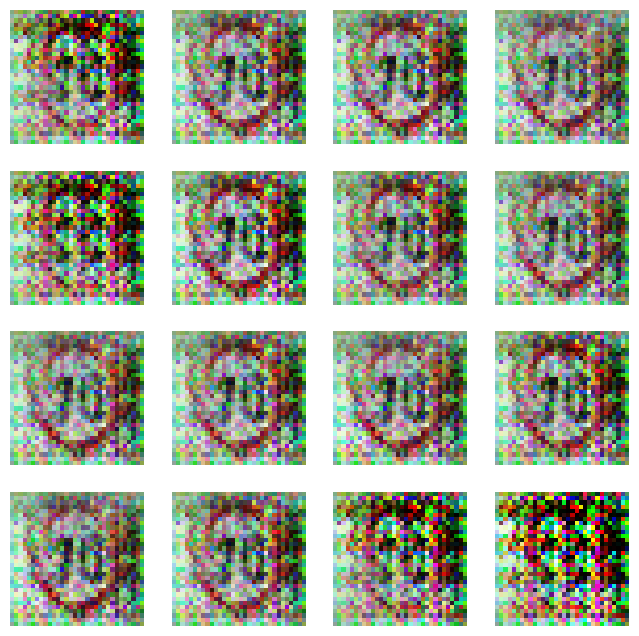

In [17]:
images = generate_images(netG, 16)  # Generate 16 images
show_images(images)